In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import statsmodels.api as sm
import os
import pathlib

from xgboost import XGBClassifier, XGBRegressor

from austen_plots.AustenPlot import AustenPlot

from utils.double_ml import *
from utils.analysis import *

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
RANDOM_SEED = 42

In [3]:
wf2020 = make_wf2020(city_var=True)

weather = ['prec', 'snow', 'temp', 'temp2']
out_vars=['aqi', 'pm']
city_economic = ['pop_city', 'gdp_city', 'firm_city']
city_environmental = ['gonglu', 'emit_ww', 'emit_so1', 'emi_dust1']

In [4]:
Q_models = [LinearRegression, RandomForestRegressor, RandomForestRegressor, XGBRegressor]
Q_params = [{}, 
            {'random_state': RANDOM_SEED,
                            'n_estimators': 100,
                            'max_depth': 10},
            {'random_state': RANDOM_SEED,
                            'n_estimators': 100,
                            'max_depth': 3},
            {'n_jobs': 1,
             'objective': 'reg:squarederror'},
           ]
g_models = [LogisticRegression, RandomForestClassifier, RandomForestClassifier, XGBClassifier]
g_params = [{'max_iter':1000},
            {'random_state': RANDOM_SEED,
                            'n_estimators': 100,
                            'max_depth': 10},
           {'random_state': RANDOM_SEED,
                            'n_estimators': 100,
                            'max_depth': 3},
           {'use_label_encoder': False, 
            'n_jobs': 1, 
            'objective': 'binary:logistic', 
            'eval_metric': 'logloss'}]

In [5]:
out_var_list_single = []
g_model_list_single = []
ps_list_single = []
g_min_list_single = []
g_max_list_single = []

for out_var in out_vars:
    print("======= ", out_var, "=======")
    for i in range(0, len(Q_models)):
        _, _, _, g_model = single_period_estimate(wf2020, treat_day=8436, outcome_var=out_var, 
                                              confounder_list=weather + city_economic + city_environmental,
                                              Q_model_class=Q_models[i], Q_model_params=Q_params[i],
                                              g_model_class=g_models[i], g_model_params=g_params[i])
        ps = get_ps(g_model, wf2020, 8436, out_var, weather + city_economic + city_environmental)
        ps_list_single.append(ps)
        g_min_list_single.append(min(ps))
        g_max_list_single.append(max(ps))
        g_model_list_single.append(get_model_string(g_models[i], g_params[i]))
        out_var_list_single.append(get_var_string(out_var))

=======  aqi =======
=======  pm =======


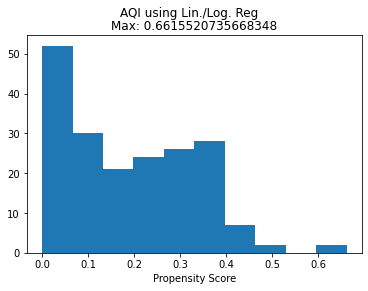

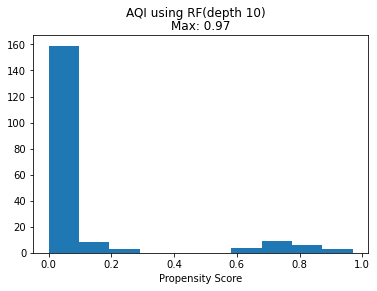

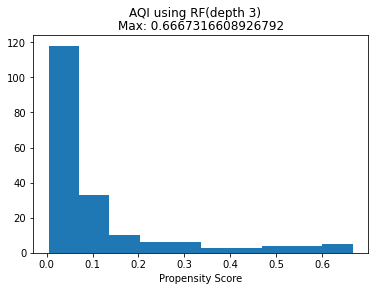

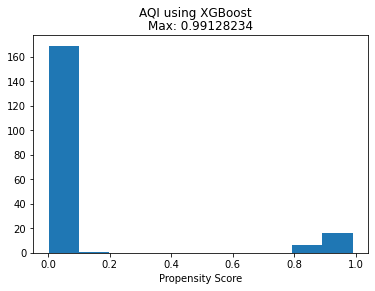

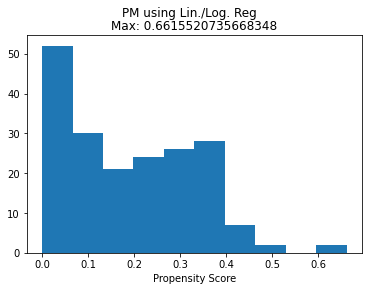

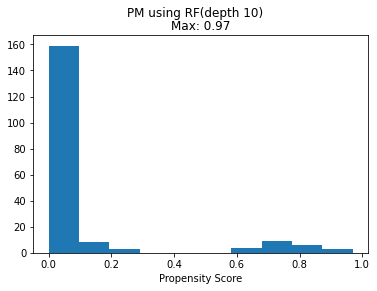

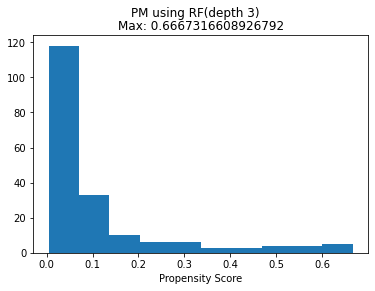

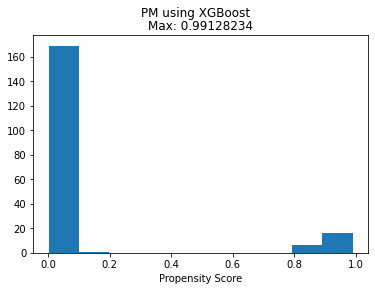

In [22]:
for i in range(0, len(ps_list_single)):
    plt.figure()
    plt.hist(ps_list_single[i])
    plt.suptitle(out_var_list_single[i] + " using " + g_model_list_single[i])
    plt.title("Max: " + str(g_max_list_single[i]))
    plt.xlabel("Propensity Score")
    plt.savefig("plots/" + 
                (out_var_list_single[i] + " using " + g_model_list_single[i]).replace(" ", "").replace("/", "").replace(".", "")
                + ".png")

### Multiple period overlap